In [4]:
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import math
from math import radians, sin, cos, sqrt
import os
import geopandas as gpd
import psycopg2
import ast
import matplotlib.pyplot as plt
import datetime
from psycopg2 import sql
from psycopg2.extras import Json
from shapely.geometry import LineString, mapping, box, Polygon, Point
from shapely import wkt
from shapely.wkb import loads
import shapely
import json
from myutil import *
import scipy
import myutil
import pickle

from geopy.distance import great_circle
from scipy.spatial import KDTree, cKDTree
from sklearn.neighbors import NearestNeighbors
#from pykdtree.kdtree import KDTree
from sklearn.neighbors import BallTree
import pykdtree
import rtree 
import pyqtree 
import quads
from quads import QuadTree
from pygeos import STRtree

# Init (same as task 1)

In [5]:
df = pd.read_csv("final_data.csv")

In [6]:
try:
    # connect to the database
    connection = psycopg2.connect(
    host="localhost",
    port="5432",
    dbname="taxi_trajectory",
    user="postgres",
    password="123456"
    )
    cursor = connection.cursor()
    print("Connected!")
except print(0):
    print("Connect error!")

Connected!


In [10]:
# close connection
if connection:
    cursor.close()
    connection.close()
    print("PostgreSQL connection is closed")

PostgreSQL connection is closed


In [ ]:
query = "SELECT trip_id, timestamp, geom FROM taxi_trips"
cursor.execute(query)
rows = cursor.fetchall()

In [7]:
select_start_end_points_query = "SELECT trip_id, timestamp, start_long, start_lat, end_long, end_lat, geom FROM taxi_trips"
cursor.execute(select_start_end_points_query)
rows = cursor.fetchall()

# Create indecies (R-tree) (KD-tree, but failed in result)

In [8]:
# R-tree
p = rtree.index.Property()
p.dimension = 3  # Three dimensions: x, y, and timestamp
myrtree = rtree.index.Index(properties=p)
t1 = datetime.datetime.now()
for row in rows:
    trip_id, timestamp, start_long, start_lat, end_long, end_lat, geom_wkt = row
    #geom = loads(geom_wkt)
    myrtree.insert(int(trip_id), (start_long, start_lat, timestamp, start_long, start_lat, timestamp))
t2 = datetime.datetime.now()
print("Execution time:", t2 - t1)
rtree_creation_time = t2 - t1

Execution time: 0:01:42.959127


In [218]:
# KD-tree  - create points
# trip_id, timestamp, start_long, start_lat, end_long, end_lat, geom
t1 = datetime.datetime.now()
points = []
for row in rows:
    trip_id, timestamp, start_long, start_lat, end_long, end_lat, geom_wkt = row
    #geom = loads(geom_wkt)
    #if start_timestamp <= timestamp <= end_timestamp:
    #points.append((start_long, start_lat, timestamp, trip_id)) # 3D
    points.append((start_long, start_lat, trip_id)) # 2D

points_array = np.array(points)
t2 = datetime.datetime.now()
print("Execution time:", t2 - t1)

Execution time: 0:00:00.964841


In [213]:
points_array[:, :2]

array([[-8.624556, 41.183811],
       [-8.685801, 41.164695],
       [-8.606457, 41.144607],
       ...,
       [-8.611119, 41.149467],
       [-8.628327, 41.157441],
       [-8.630478, 41.154471]])

In [248]:
# just add the start longitude, start latitude for this query. I will filter the timestamp later
# I'm trying to avoid the curve of dimensionality. 
# The distance will become larger if there're a lot of dimensions added.
# Although my dimensions are not too much
#mykdtree = KDTree(points_array[:, :3]) # 3D
mykdtree = cKDTree(points_array[:, :2]) # 2D

# Query: KNN - Find k nearest neighbours (start data points / trip_ids) of a given point (x_search, y_search) for a given time range (start_timestamp, end_timestamp)

Explain my query: Given a point with {x_search, y_search}, a time range from {start_timestamp} to {end_timestamp}, find k-nearest neighbors, then return their {trip_ids}

## Set up

In [9]:
# max timestamp: 1393230201    min timestamp: 1372636853
# 2013-07-01 10:00:53            2014-02-24 18:23:21
# 41.1607172,-8.6424799  41.1636687,-8.627035
start_datetime = datetime.datetime(2013, 10, 1, 0, 0, 0)
end_datetime = datetime.datetime(2013, 10, 2, 0, 0, 0)
start_timestamp = int(start_datetime.timestamp())
end_timestamp = int(end_datetime.timestamp())
# search point
minx_search, miny_search, maxx_search, maxy_search = -8.6424799, 41.1607172, -8.6424799, 41.1607172
print("start timestamp: ", start_timestamp, "         datetime:", start_datetime)
print("end timestamp: ", end_timestamp, "           datetime:", end_datetime)
print("Searching area: ", minx_search, miny_search, maxx_search, maxy_search)
print("Searching area: ", minx_search, ",", miny_search,",", maxx_search,",", maxy_search)
create_map_with_bb(minx_search, miny_search, maxx_search, maxy_search)

start timestamp:  1380549600          datetime: 2013-10-01 00:00:00
end timestamp:  1380636000            datetime: 2013-10-02 00:00:00
Searching area:  -8.6424799 41.1607172 -8.6424799 41.1607172
Searching area:  -8.6424799 , 41.1607172 , -8.6424799 , 41.1607172


## DB query

In [29]:
k = 10
knn_db_query = """SELECT trip_id
FROM taxi_trips
WHERE timestamp BETWEEN {} AND {}
ORDER BY ST_DistanceSphere(ST_SetSRID(ST_MakePoint(start_long, start_lat), 4326), ST_SetSRID(ST_MakePoint({}, {}), 4326))
--ORDER BY ST_SetSRID(ST_MakePoint(start_long, start_lat), 4326) <-> ST_SetSRID(ST_MakePoint(-8.6424799, 41.1607172), 4326)
LIMIT {};""".format(start_timestamp, end_timestamp, minx_search, miny_search, k)

In [30]:
t1 = datetime.datetime.now()
cursor.execute(knn_db_query)
t2 = datetime.datetime.now()
print("Execution time: ", t2 - t1)
db_query_time = t2 - t1
query2_result_db = cursor.fetchall()
print(len(query2_result_db))

Execution time:  0:00:00.473675
10


In [105]:
query2_result_db

[(1380568647620000577,),
 (1380622284620000436,),
 (1380626783620000542,),
 (1380581343620000518,),
 (1380616768620000167,),
 (1380606752620000903,),
 (1380616036620000669,),
 (1380567732620000065,),
 (1380615838620000324,),
 (1380586075620000431,)]

## R-tree query

In [14]:
# If I choose 2D R-tree: (start_long, start_lat, start_long, start_lat) // start points
# The key thing here is how to find the suitable num_results (which is our K) for each case?
# We wanna find the 10 (k = 10) nearest neightbors within a time range, however, my r-tree only stores start coordinates without timestamp 
# We have to find more than K neighbors, then filter it later because maybe some returned trip_ids are not in that range

# But if I choose 3D R-tree: (start_long, start_lat, timestamp, start_long, start_lat, timestamp) // start points with the start timestamp
# The problem is... (I forget it @@)
t1 = datetime.datetime.now()
retured_id_rtree = myrtree.nearest((minx_search, miny_search, start_timestamp, maxx_search, maxy_search, end_timestamp), num_results=10)
t2 = datetime.datetime.now()
rtree_query_time = t2 - t1
retured_id_rtree = list(retured_id_rtree)
print("Execution time", rtree_query_time)

Execution time 0:00:00.004986


In [34]:
len(retured_id_rtree)

10

In [15]:
filtered_trip_ids_rtree = set()
trip_id_idx_list = []

for trip_id in retured_id_rtree:
   trip_id_idx_list.append(df[df['trip_id'] == trip_id].index[0])

t1 = datetime.datetime.now()
for idx in trip_id_idx_list:
    current_time_at_point = df.timestamp[idx]
    if ((current_time_at_point >= start_timestamp) & (current_time_at_point <= end_timestamp)):
        filtered_trip_ids_rtree.add(df.trip_id[idx])
       
t2 = datetime.datetime.now()
print("Execution time:", t2 - t1)
rtree_query_time += (t2 - t1)
len(filtered_trip_ids_rtree)


Execution time: 0:00:00.000997


10

In [13]:
filtered_trip_ids_rtree

{1380568647620000577,
 1380581343620000518,
 1380586075620000431,
 1380606752620000903,
 1380615838620000324,
 1380616036620000669,
 1380616768620000167,
 1380622284620000436,
 1380626783620000542,
 1380635800620000359}

In [ ]:
"""
# Analyse the result.

Result from DB.
[(1380568647620000577,),
 (1380622284620000436,),
 (1380626783620000542,),
 (1380581343620000518,),
 (1380616768620000167,),
 (1380606752620000903,),
 (1380616036620000669,),
 (1380567732620000065,),
 (1380615838620000324,),
 (1380586075620000431,)]
 
 # Result from 2D R-tree (long, lat)  
 # -> it's good, but takes a lot of time because we dont know how to select "k" as mentioned above.
 {1380567732620000065,
 1380568647620000577,
 1380581343620000518,
 1380586075620000431,
 1380606752620000903,
 1380615838620000324,
 1380616036620000669,
 1380616768620000167,
 1380622284620000436,
 1380626783620000542,
 1380635800620000359} # this one is 11th nearest neighbor
 
 # 3D R-tree (long, lat, timestamp) 
 # --> better time query, however, the higher dimension we have, the further distance we will get.
 # this may be affected by "The curve of dimensionality".
 # 1380567732620000065 <---- I dont know why this id wasn't detected in my 3D R-tree. 
 # Maybe the distance is affected by the dimensions?
 # The order is different from the DB (linear scan) 
 # because of the structure of R-tree and how it search the K-NN.
 
{1380568647620000577,
 1380581343620000518,
 1380586075620000431,
 1380606752620000903,
 1380615838620000324,
 1380616036620000669,
 1380616768620000167,
 1380622284620000436,
 1380626783620000542,
 1380635800620000359}  
"""

## KD-tree Query (scipy.spatial) (wrong result, returned trip_ids don't exist)

In [135]:
# 3D
# points.append((start_long, start_lat, timestamp, trip_id)) # 3D
target_point = [minx_search, miny_search, start_timestamp]

# Perform the K-nearest neighbor search using the KD-tree
k = 10  # Number of nearest neighbors to retrieve
kdtree_distances, kdtree_indices = mykdtree.query(target_point, k=k)


In [ ]:
# 3D
# Retrieve the nearest neighbors within the desired timestamp range
knn_trip_ids = set()
for index in kdtree_indices:
    trip_id, trip_timestamp = points_array[index, 3], points_array[index, 2]
    if start_timestamp <= trip_timestamp <= end_timestamp:
        knn_trip_ids.add(int(trip_id))

In [150]:
kdtree_indices

array([487107, 854790, 875239, 443745, 811574, 793153, 178130, 886486,
       785830, 961003], dtype=int64)

In [249]:
# 2D
# points.append((start_long, start_lat, trip_id)) # 2D
target_point = [[minx_search, miny_search]]

# Perform the K-nearest neighbor search using the KD-tree
k = 20  # Number of nearest neighbors to retrieve
kdtree_distances, kdtree_indices = mykdtree.query(target_point, k=k)

In [250]:
list(kdtree_indices)

[array([487107, 854790, 875239, 443745, 811574, 793153, 178130, 886486,
        785830, 961003, 581576, 253374,  72506, 310817, 844472, 930792,
        779346, 925547, 114007, 663911], dtype=int64)]

In [251]:
int(points_array[779346][2])

1388437071620001024

In [244]:
# 1380626783620000542
# 1374241589620000256
# what the... ? This id is not in my data .-.
df[df['trip_id'] == 1374241589620000256]

,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,day_type,polyline,distance,start_lat,start_long,end_lat,end_long,geom,total_time


In [252]:
# Retrieve trip information for the nearest neighbors
for distance, index in zip(kdtree_distances[0], kdtree_indices[0]):
    trip_id = int(points_array[index][2])  
    print(f"Trip ID: {trip_id}, Distance: {distance}")


Trip ID: 1374241589620000256, Distance: 4.283514912134659e-05
Trip ID: 1390083240620001024, Distance: 0.0002972403909281925
Trip ID: 1390573348620000512, Distance: 0.00032033302982719633
Trip ID: 1373358554620000256, Distance: 0.0003897307403837919
Trip ID: 1389101014620000512, Distance: 0.0004183668844461827
Trip ID: 1388672785620000000, Distance: 0.00042313904334438304
Trip ID: 1380103592620000256, Distance: 0.000436194967874265
Trip ID: 1390836332620000512, Distance: 0.00043750114285435283
Trip ID: 1388547280620000256, Distance: 0.000442992155688562
Trip ID: 1392414781620000000, Distance: 0.00044401289395435887
Trip ID: 1376272542620000512, Distance: 0.0004496906158696986
Trip ID: 1381519508620000000, Distance: 0.00045132876044269956
Trip ID: 1378358136620000000, Distance: 0.0004546289146105715
Trip ID: 1382608763620000768, Distance: 0.0004570002735245898
Trip ID: 1389866240620000000, Distance: 0.0004615095340296241
Trip ID: 1391793904620000512, Distance: 0.0004618292433354096
Trip 

## Linear scan

In [38]:
k = 11
nearest_neighbors_linear_scan = []
target_point = (minx_search, miny_search)
t1 = datetime.datetime.now()
for row in rows:
    trip_id, timestamp, start_long, start_lat, end_long, end_lat, geom_wkt = row
    point = (start_long, start_lat)
    
    # Check if the timestamp is within the specified range
    if start_timestamp <= timestamp <= end_timestamp:
        distance = myutil.haversine_distance(target_point, point)
        #distance = great_circle(target_point, point)   # alternative distance calculation function
        
        nearest_neighbors_linear_scan.append((trip_id, point, distance))

# Sort the nearest neighbors based on the distance
nearest_neighbors_linear_scan.sort(key=lambda x: x[2])

# Retrieve the top K nearest neighbors
k_nearest_neighbors_linear_scan = nearest_neighbors_linear_scan[:k]
t2 = datetime.datetime.now()
print("Execution time", t2 - t1)
linear_scan_query_time = t2 - t1

Execution time 0:00:00.427306


In [39]:
k_nearest_neighbors_linear_scan

[(1380568647620000577, (-8.642358, 41.160177), 0.060912819730363846),
 (1380622284620000436, (-8.643087, 41.160276), 0.08312396121171221),
 (1380626783620000542, (-8.641458, 41.160132), 0.13057762039044904),
 (1380581343620000518, (-8.641485, 41.159907), 0.14202660374398585),
 (1380616768620000167, (-8.643969, 41.160393), 0.169372800905288),
 (1380606752620000903, (-8.640954, 41.16096), 0.17175921173761502),
 (1380616036620000669, (-8.641278, 41.159727), 0.17236752959382678),
 (1380635800620000359, (-8.641026, 41.159727), 0.19489883293014615),
 (1380615838620000324, (-8.64081, 41.160096), 0.19784425111726184),
 (1380586075620000431, (-8.640819, 41.160033), 0.19941311087998978),
 (1380567732620000065, (-8.640738, 41.161158), 0.19966046964626352)]

## Quad-Tree query (fail, my computer crashed)

In [256]:
# This library doesnt support KNN search
#mypqtree = pyqtree.Index(bbox=(-9.33309, 38.564424, -6.273549, 42.051402))

In [55]:
minx_entire = -9.33309
miny_entire = 38.564424
maxx_entire = -6.273549
maxy_entire = 42.051402

# Calculate central point
center_lon = (minx_entire + maxx_entire) / 2
center_lat = (miny_entire + maxy_entire) / 2
central_point = (center_lon, center_lat)
print("Central Point:", central_point)

# Calculate width
width = maxx_entire - minx_entire
print("Width:", width)

# Calculate height
height = maxy_entire - miny_entire
print("Height:", height)


Central Point: (-7.803319500000001, 40.307913)
Width: 3.0595410000000003
Height: 3.4869780000000006


In [56]:
mypqtree = quads.QuadTree(
    (-7.803319500000001, 40.307913),  # central point
    3.0595410000000003, # width
    3.4869780000000006 # height
)

In [57]:
# My computer crashed when I tried to run this cell :( 
# So I can't apply this data structure
t1 = datetime.datetime.now()
for row in rows:
    trip_id, timestamp, start_long, start_lat, end_long, end_lat, geom_wkt = row
    geom = Point(start_long, start_lat)
    mypqtree.insert(point=geom.bounds, data=trip_id)
t2 = datetime.datetime.now()
print("Execution time", t2 - t1)

: 

: 

## KD-tree Sklearn

In [7]:
points = []
timestamps = []
t1 = datetime.datetime.now()
for row in rows:
    trip_id, timestamp, start_long, start_lat, end_long, end_lat, geom_wkt = row
    points.append((start_long, start_lat))
    timestamps.append(timestamp)
myknn_sklearn = NearestNeighbors(n_neighbors=3000, algorithm='kd_tree')
myknn_sklearn.fit(points)
t2 = datetime.datetime.now()
print("Execution time", t2 - t1)
kdtree_sklearn_creation_time = t2 - t1

Execution time 0:00:02.547452


In [44]:
target_point = [[minx_search, miny_search]]

t1 = datetime.datetime.now()
kdtree_sklearn_distances, kdtree_sklearn_indices = myknn_sklearn.kneighbors(target_point)

kdtree_sklearn_result = set()
# Retrieve the nearest neighbors' information within the timestamp range
for distance, index in zip(kdtree_sklearn_distances[0], kdtree_sklearn_indices[0]):
    nearest_point = points[index]
    trip_id = rows[index][0]  # Extract trip_id from the corresponding row
    timestamp = timestamps[index]  # Extract timestamp from the corresponding row

    if start_timestamp <= timestamp <= end_timestamp:
        kdtree_sklearn_result.add(trip_id)
        #print(f"Trip ID: {trip_id}, Timestamp: {timestamp}, Nearest Point: {nearest_point}, Distance: {distance}")


t2 = datetime.datetime.now()
print("Execution time", t2 - t1)
kdtree_sklearn_query_time = t2 - t1

Execution time 0:00:00.006981


In [45]:
kdtree_sklearn_result

{1380567732620000065,
 1380568647620000577,
 1380581343620000518,
 1380586075620000431,
 1380606752620000903,
 1380615838620000324,
 1380616036620000669,
 1380616768620000167,
 1380622284620000436,
 1380626783620000542,
 1380635800620000359}

## Ball-Tree Sklearn

In [8]:
# same as R-tree, to find K-NN in a time range is quite hard to determine the exact number of n_neighbors initially
# In my experiment, if n_neighbors = 3000, the final returned trip_ids will be 11 nearest neighbors
points = []
timestamps = []
t1 = datetime.datetime.now()
for row in rows:
    trip_id, timestamp, start_long, start_lat, end_long, end_lat, geom_wkt = row
    points.append((start_long, start_lat))
    timestamps.append(timestamp)
myballtree_sklearn = NearestNeighbors(n_neighbors=3000, algorithm='ball_tree')
myballtree_sklearn.fit(points)
t2 = datetime.datetime.now()
print("Execution time", t2 - t1)
balltree_sklearn_creation_time = t2 - t1

Execution time 0:00:02.308258


In [47]:
target_point = [[minx_search, miny_search]]

t1 = datetime.datetime.now()
balltree_sklearn_distances, balltree_sklearn_indices = myknn_sklearn.kneighbors(target_point)

balltree_sklearn_result = set()
# Retrieve the nearest neighbors' information within the timestamp range
for distance, index in zip(balltree_sklearn_distances[0], balltree_sklearn_indices[0]):
    nearest_point = points[index]
    trip_id = rows[index][0]  # Extract trip_id from the corresponding row
    timestamp = timestamps[index]  # Extract timestamp from the corresponding row

    if start_timestamp <= timestamp <= end_timestamp:
        balltree_sklearn_result.add(trip_id)
        #print(f"Trip ID: {trip_id}, Timestamp: {timestamp}, Nearest Point: {nearest_point}, Distance: {distance}")


t2 = datetime.datetime.now()
print("Execution time", t2 - t1)
balltree_sklearn_query_time = t2 - t1

Execution time 0:00:00.005983


In [48]:
balltree_sklearn_result

{1380567732620000065,
 1380568647620000577,
 1380581343620000518,
 1380586075620000431,
 1380606752620000903,
 1380615838620000324,
 1380616036620000669,
 1380616768620000167,
 1380622284620000436,
 1380626783620000542,
 1380635800620000359}

# Compare performance

## Creation time

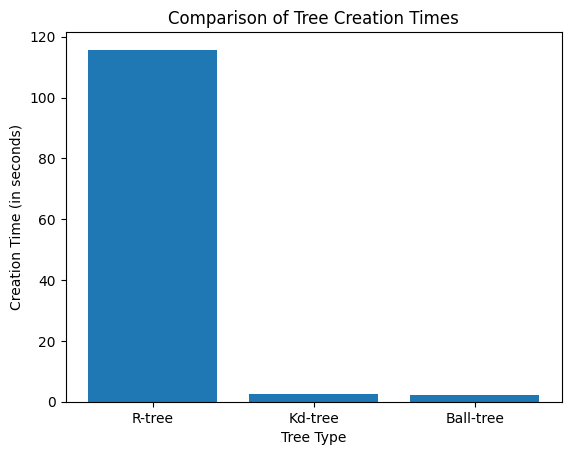

In [9]:
creation_time_all = {'R-tree': rtree_creation_time.total_seconds(), 
                     'Kd-tree': kdtree_sklearn_creation_time.total_seconds(), 
                     'Ball-tree': balltree_sklearn_creation_time.total_seconds()}

plt.bar(creation_time_all.keys(), creation_time_all.values())
plt.xlabel('Tree Type')
plt.ylabel('Creation Time (in seconds)')
plt.title('Comparison of Tree Creation Times')
plt.show()

## Query time

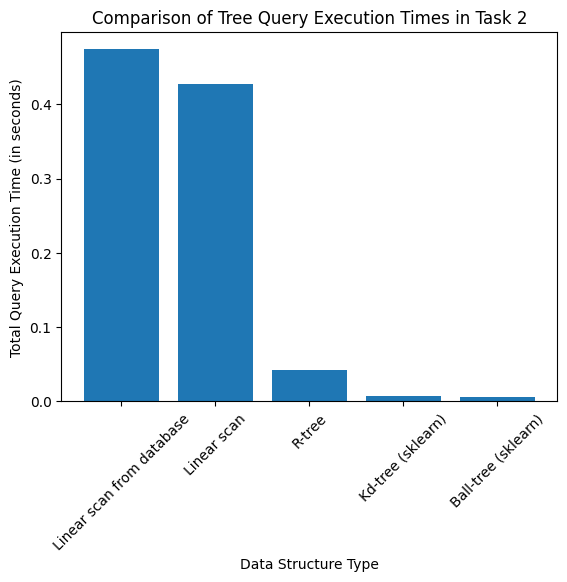

In [54]:
query_time_all = {'Linear scan from database': db_query_time.total_seconds(),
                  'Linear scan': linear_scan_query_time.total_seconds(),
                  'R-tree': rtree_query_time.total_seconds(), 
                  'Kd-tree (sklearn)': kdtree_sklearn_query_time.total_seconds(), 
                  'Ball-tree (sklearn)': balltree_sklearn_query_time.total_seconds()}

plt.bar(query_time_all.keys(), query_time_all.values())

plt.xlabel('Data Structure Type')
plt.ylabel('Total Query Execution Time (in seconds)')
plt.title('Comparison of Tree Query Execution Times in Task 2')
plt.xticks(rotation=45)
plt.show()